**Tweet spam generator**

Our goal is to code a bot that can output realistic tweets. For that purpose, we are given a dataset of 100k tweets. The first part will be to train an encoder/decoder that we can use as a generator. The second part will be to train our generator using an adversarial critic that distinguish between real tweets and generated tweets

In [0]:
import numpy as np
import tensorflow as tf

In [0]:
!wget http://perso-etis.ensea.fr/picard/tweets_100k.txt;

--2019-06-05 09:46:43--  http://perso-etis.ensea.fr/picard/tweets_100k.txt
Resolving perso-etis.ensea.fr (perso-etis.ensea.fr)... 193.51.45.246
Connecting to perso-etis.ensea.fr (perso-etis.ensea.fr)|193.51.45.246|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://perso-etis.ensea.fr//picard/tweets_100k.txt [following]
--2019-06-05 09:46:44--  https://perso-etis.ensea.fr//picard/tweets_100k.txt
Connecting to perso-etis.ensea.fr (perso-etis.ensea.fr)|193.51.45.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6267498 (6.0M) [text/plain]
Saving to: ‘tweets_100k.txt.1’

tweets_100k.txt.1   100%[===================>]   5.98M  6.64MB/s    in 0.9s    

2019-06-05 09:46:45 (6.64 MB/s) - ‘tweets_100k.txt.1’ saved [6267498/6267498]



**Prepare dataset**

convert string to sequences of integer and pad right with zeros

In [0]:
tweets = []
with open('tweets_100k.txt', 'r') as f:
  for line in f:
    tweets.append(line)

In [0]:
# Générateur de phrases en anglais
# Copié et adapté depuis http://pythonfiddle.com/random-sentence-generator/
import random

s_nouns = ["A dude", "My mom", "The king", "Some guy", "A cat with rabies", "A sloth", "Your homie", "This cool guy my gardener met yesterday", "Superman"]
p_nouns = ["These dudes", "Both of my moms", "All the kings of the world", "Some guys", "All of a cattery's cats", "The multitude of sloths living under your bed", "Your homies", "Like, these, like, all these people", "Supermen"]
s_verbs = ["eats", "kicks", "gives", "treats", "meets with", "creates", "hacks", "configures", "spies on", "retards", "meows on", "flees from", "tries to automate", "explodes"]
p_verbs = ["eat", "kick", "give", "treat", "meet with", "create", "hack", "configure", "spy on", "retard", "meow on", "flee from", "try to automate", "explode"]
infinitives = ["to make a pie \n", "for no apparent reason \n", "because the sky is green \n", "for a disease \n", "to be able to make toast explode \n", "to know more about archeology \n"]
def gen():
  return ' '.join((random.choice(s_nouns), random.choice(s_verbs), random.choice(p_nouns).lower(), random.choice(infinitives)))

def gen_n(n):
  tweets_test = []
  for i in range(n):
    tweets_test.append(gen())
  return tweets_test

In [0]:
def tweet_encoder(tweets):
  x = []
  for t in tweets:
    x.append([ord(c) for c in t])
  x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=140, padding='post', value=0)
  return np.array(x)

In [0]:
X_train = tweet_encoder(tweets)

X_test =  tweet_encoder(gen_n(100))

**Create batch generator**

Converting the list of integers to one-hot vectors would exhaust the memory. The generator allows us to generate the large sparse vectors on the fly, only when needed

In [0]:
class TweetSequence(tf.keras.utils.Sequence):
  def __init__(self, x, batch_size=32):
    self.x = x
    self.batch_size = batch_size
  def __len__(self):
    return len(self.x)//self.batch_size
  def __getitem__(self, idx):
    batch = self.x[idx*self.batch_size:(idx+1)*self.batch_size, :]
    batch = tf.keras.utils.to_categorical(batch, num_classes=256)
    return batch, batch

**Create autoencoder model**

Create a deep neural network that encodes and decodes the character string. The objective is to perform reconstruction, that is, recovering the same one hot sequence as the input at the output.

In [0]:
X_train = TweetSequence(X_train)
X_test = TweetSequence(X_test)

## Test avec layer Dense fully connected
Cela implique trop de paramètres, et en tenant compte de la présence de LSTM, l'entraînement est trop long.
On testera par la suite un autre modèle.

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential

timesteps = 140
input_dim = 256

encoder_inputs = Input(shape=(timesteps, input_dim))
encoder_lstm = CuDNNLSTM(input_dim)(encoder_inputs)

decoder_inputs = Input(shape=(input_dim,))
decoder_dense = Dense(timesteps*input_dim)(decoder_inputs)
decoder_reshape = Reshape((timesteps, input_dim))(decoder_dense)
decoder_lstm = CuDNNLSTM(input_dim, return_sequences=True)(decoder_reshape)
decoder_outputs = Activation('softmax')(decoder_reshape)

encoder = Model(inputs=encoder_inputs, outputs=encoder_lstm)
decoder = Model(inputs=decoder_inputs, outputs=decoder_outputs)

encoder.summary()
decoder.summary()

sequence_autoencoder = Sequential()
sequence_autoencoder.add(encoder)
sequence_autoencoder.add(decoder)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 140, 256)          0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 256)               526336    
Total params: 526,336
Trainable params: 526,336
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 35840)             9210880   
_________________________________________________________________
reshape_1 (Reshape)          (None, 140, 256)          0         
_________________________________________________________________
acti

In [0]:
sequence_autoencoder.compile(optimizer='rmsprop', loss='categorical_crossentropy')
sequence_autoencoder.fit_generator(x_seq, epochs=5)

Epoch 1/5
3125/3125 [==============================] - 286s 92ms/step - loss: 3.9043
Epoch 2/5
3125/3125 [==============================] - 279s 89ms/step - loss: 3.8550
Epoch 3/5
3125/3125 [==============================] - 280s 90ms/step - loss: 3.8536
Epoch 4/5
 484/3125 [===>..........................] - ETA: 3:55 - loss: 3.8547

KeyboardInterrupt: ignored

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential

timesteps = 140
input_dim = 256

encoder_inputs = Input(shape=(timesteps, input_dim))
x = Conv1D(32, 3, activation='relu', padding='same')(encoder_inputs)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(8, 3, activation='relu', padding='same')(x)
encoded = Flatten()(x)

decoder_inputs = Input(shape=(280,))
x = Reshape((35,8))(decoder_inputs)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(256, 3, activation='softmax', padding='same')(x)

encoder = Model(inputs=encoder_inputs, outputs=encoded)
decoder = Model(inputs=decoder_inputs, outputs=decoded)

encoder.summary()
decoder.summary()

sequence_autoencoder = Sequential()
sequence_autoencoder.add(encoder)
sequence_autoencoder.add(decoder)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140, 256)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 140, 32)           24608     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 70, 16)            1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 35, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 8)             392       
_________________________________________________________________
flatten (Flatten)            (None, 280)               0         
Total para

In [0]:
sequence_autoencoder.compile(optimizer='adadelta', loss='categorical_crossentropy')
sequence_autoencoder.fit_generator(x_seq, epochs=30)

Epoch 1/30
3125/3125 [==============================] - 65s 21ms/step - loss: 1.1008
Epoch 2/30
3125/3125 [==============================] - 62s 20ms/step - loss: 0.8385
Epoch 3/30
3125/3125 [==============================] - 62s 20ms/step - loss: 0.7461
Epoch 4/30
3125/3125 [==============================] - 62s 20ms/step - loss: 0.6453
Epoch 5/30
3125/3125 [==============================] - 62s 20ms/step - loss: 0.5681
Epoch 6/30
3125/3125 [==============================] - 62s 20ms/step - loss: 0.5312
Epoch 7/30
3125/3125 [==============================] - 62s 20ms/step - loss: 0.5042
Epoch 8/30
3125/3125 [==============================] - 62s 20ms/step - loss: 0.4831
Epoch 9/30
3125/3125 [==============================] - 62s 20ms/step - loss: 0.4673
Epoch 10/30
3125/3125 [==============================] - 62s 20ms/step - loss: 0.4544
Epoch 11/30
3125/3125 [==============================] - 61s 20ms/step - loss: 0.4443
Epoch 12/30
3125/3125 [==============================] - 61s 20

Le score de loss paraît bon (on pourrait mettre plus d'epochs pour l'améliorer), on va maintenant tester le modèle sur un tweet.

In [0]:
sequence_autoencoder.save('auto1.h5')

In [0]:
from tensorflow.keras.models import load_model
sequence_autoencoder = load_model('auto1.h5') # pour éviter de devoir réentraîner le model tous les jours

In [0]:
def argmax(x_pred):
  return [np.argmax(tweet, axis=1) for tweet in x_pred]

def char_decoder(x_pred):
  """Traduit les chaînes de nombres en caractères"""
  arr = []
  for tweet in x_pred:
    arr.append(''.join([chr(c) for c in tweet if c != 0]))
  return np.array(arr)

In [0]:
x_pred = sequence_autoencoder.predict(x_test_seq)
x_pred = char_decoder(argmax(x_pred))

In [0]:
print(x_pred[1])
print(x_t[1])

A dode conniniree your cimeee to be ab0e to make toast sxmeode 

A dude configures your homies to be able to make toast explode 



Le modèle fonctionne bien, il y a des erreurs mais c'était attendu : la "loss" n'est pas nulle, et cette loss est due aux pertes lors du décodage car on compresse les données sur un espace de moindres dimensions lors de l'encodage puis on les décompresse sur un espace de plus grandes dimensions lors du décodage.

**Create adversarial model**

Use the decoder architecture as a generator and create a discriminator that classifies tweets as generated or real. Write a custom training loop that performs the folowing:


1.   Get a batch of real tweets
2.   Generates a batch of generated tweets
3.   Train the discriminator to classify real/generated using the union of both batch
4.   Train the generator (discriminator is not trainable) to classify generated tweets as real



In [0]:
inter_encoder = Sequential()
inter_encoder.add(sequence_autoencoder.layers[0])
inter_encoder.compile(optimizer='adadelta', loss='categorical_crossentropy')
inter_encoder.set_weights(sequence_autoencoder.get_weights())
inter_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 280)               26552     
Total params: 26,552
Trainable params: 26,552
Non-trainable params: 0
_________________________________________________________________


In [0]:
prediction = inter_encoder.predict(x_test_seq)
prediction.shape

(96, 280)

In [0]:
import seaborn as sns
import scipy.stats as stats

lower, upper = np.min(prediction), np.max(prediction)
mu = np.mean(prediction)
sigma = np.std(prediction)
print(mu, sigma)
print(lower, upper)

1.6501276 1.781072
0.0 8.196584


In [0]:
sns.distplot(prediction[2], hist = False, kde = True, rug = True,
             color = 'darkblue', 
             kde_kws={'linewidth': 3},
             rug_kws={'color': 'black'})

NameError: ignored

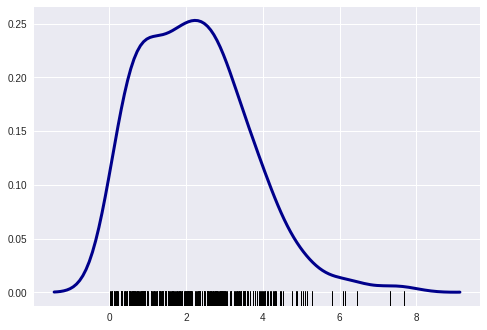

In [0]:
# On simule un tweet par une distribution gaussienne tronquée au min et max de 
# la distribution réelle pour garder une densité de probabilité cohérente

enct = stats.truncnorm((lower - mu) / sigma,
                           (upper - mu) / sigma,
                           loc=mu,
                           scale=sigma)
genpred = np.array([enct.rvs(280) for _ in range(100)]) # 100 tweets
sns.distplot(genpred[25], hist = False, kde = True, rug = True,
             color = 'darkblue', 
             kde_kws={'linewidth': 3},
             rug_kws={'color': 'black'})

In [0]:
inter_decoder = Model(inputs=decoder_inputs, outputs=decoded)
inter_decoder.set_weights(sequence_autoencoder.layers[1].get_weights())

In [0]:
generated_tweets = inter_decoder.predict(genpred)
generated_tweets = char_decoder(argmax(generated_tweets))
print(generated_tweets[50])

Ntt _uho topus 20 ? tgoddfoom thhhoh Mo?'hebbacf. fotf/?t&mbb;t ohom. hh ofoopfeeplr. gh hhll Toll thobw. y borr.&o hob thocomKono_@*sttst



On doit pouvoir obtenir mieux que ça en utilisant le décodeur, ça ne doit pas être la bonne manière de faire ?
Reste à écrire l'adversarial network.